<a href="https://colab.research.google.com/github/Ghosty032/Ghosty032/blob/main/Stock_Price_Prediction_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
device = torch.device('cuda'if torch.cuda.is_available()else 'cpu')

In [ ]:
ticker = "TSLA"  # Apple stock (change to any ticker)
start_date = "2010-01-01"
end_date = "2023-12-31"

data = yf.download(ticker, start=start_date, end=end_date)
data = data[['Close']]
data

/tmp/ipython-input-5-1375145441.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,TSLA
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000
...,...
2023-12-22,252.539993
2023-12-26,256.609985


In [ ]:
#PreProcessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [ ]:
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

X = X.reshape(X.shape[0], X.shape[1], 1)


In [ ]:
# Step 6: Split data into train/test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
#Building a LSTM MODEL
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# Step 8: Train the model
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=20,
                    validation_data=(X_test, y_test))

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0053 - val_loss: 0.0033
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.2999e-04 - val_loss: 0.0035
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.8062e-04 - val_loss: 0.0048
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.6180e-04 - val_loss: 0.0055
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.0967e-04 - val_loss: 0.0023
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.5111e-04 - val_loss: 0.0026
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.2196e-04 - val_loss: 0.0024
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4215e-04 - val_loss: 0.0057
Epoch 9/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.3156e-04 - val_loss: 0.0038
Epoch 10/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6534e-04 - val_loss: 0.0020
Epoch 11/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.3532e-04 - val_loss: 0.0019
Epoch 12/20
84/84 ━━━━━━━━

In [ ]:
# Step 9: Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
# Inverse transform to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))


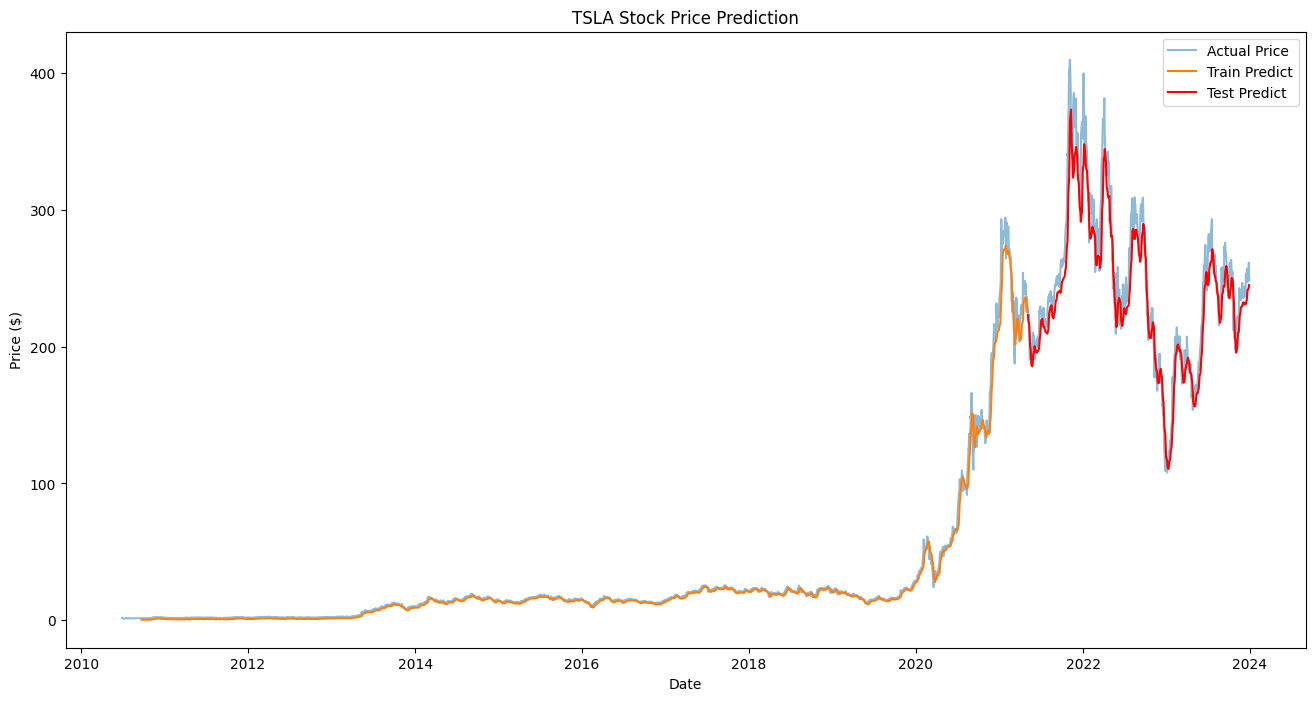

In [ ]:
plt.figure(figsize=(16,8))

# Plot actual prices
plt.plot(data.index, data['Close'], label='Actual Price', alpha=0.5)

# Plot training predictions (aligned with middle of each window)
train_dates = data.index[time_step : train_size + time_step]
plt.plot(train_dates, train_predict, label='Train Predict')

# Plot test predictions (correct alignment)
test_dates = data.index[train_size + time_step : train_size + time_step + len(test_predict)]
plt.plot(test_dates, test_predict, label='Test Predict', color='red')

plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [ ]:
# Step 11: Evaluate model
from sklearn.metrics import mean_squared_error
print("Train RMSE:", np.sqrt(mean_squared_error(y_train_orig, train_predict)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test_orig, test_predict)))

Train RMSE: 4.342741495124093
Test RMSE: 18.948130804108814
